## Femininity vs Masculinity

### Dataset characteristics: 
* Heterosexual audience
* Bay-Area-based (aligned with the fact that okCupid is an startup; 99.85% based in California; ~95% from Bay Area)
* Educated (39,631 (66%) users with at least a bachelor's degree)
* Young (around 72% is <35 years old)

### Notebook roadmap (run top → bottom)

1. **Setup & data loading**  
2. **Text cleaning**
3. **Sanity checks & quick EDA**  
4. **Stakeholder visualizations** (offspring + body type)  
5. **Model-based analysis** (keywords + classifier coefficients)  
6. **NLP analysis** (topic modeling + emotion analysis)

## 1) Data loading

In [1]:
# Download the dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "okcupid_profiles.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "andrewmvd/okcupid-profiles",
    file_path,
)

/Users/gabisa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gabisa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/9j/j13nrnyx1mzfr87mqcn7zpqh0000gn/T/ipykernel_5952/3418947772.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [2]:
# Check Dataset
df.head(5)
# Get the number of columns
print(df.columns.tolist())

['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'height', 'income', 'job', 'last_online', 'location', 'offspring', 'pets', 'religion', 'sign', 'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']


## 2) Text cleaning

In [3]:
#Combine all Essay Columns 
import pandas as pd

essay_cols = [f"essay{i}" for i in range(10)]
df["text"] = df[essay_cols].fillna("").agg(" ".join, axis=1)

In [4]:
# Clean texts
import re

def clean(s):
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

df["clean_text"] = df["text"].apply(clean)

## 3) Sanity checks & EDA

In [5]:
# Count people with age <= 35
age_35_or_below = df[df['age'] <= 35]
count_35_or_below = len(age_35_or_below)

print(f"Number of people with age <= 35: {count_35_or_below}")
print(f"Total number of people: {len(df)}")
print(f"Percentage: {count_35_or_below / len(df) * 100:.2f}%")

Number of people with age <= 35: 43075
Total number of people: 59946
Percentage: 71.86%


In [6]:
# Count people in California
# Filter for locations containing ", california" (case-insensitive)
california_people = df[df['location'].str.contains(', california', case=False, na=False)]
count_california = len(california_people)

print(f"Number of people in California: {count_california}")
print(f"Total number of people: {len(df)}")
print(f"Percentage: {count_california / len(df) * 100:.2f}%")

# Show some examples of California locations
print(f"\nSample California locations:")
print(california_people['location'].value_counts().head(25))

Number of people in California: 59855
Total number of people: 59946
Percentage: 99.85%

Sample California locations:
location
san francisco, california          31064
oakland, california                 7214
berkeley, california                4212
san mateo, california               1331
palo alto, california               1064
alameda, california                  910
san rafael, california               755
hayward, california                  747
emeryville, california               738
redwood city, california             693
daly city, california                681
san leandro, california              651
walnut creek, california             644
vallejo, california                  558
menlo park, california               479
richmond, california                 424
south san francisco, california      416
mountain view, california            384
novato, california                   369
burlingame, california               361
pleasant hill, california            347
castro valley

In [7]:
print(df['education'].unique())
print(df['age'].unique())
print(df['location'].value_counts())

['working on college/university' 'working on space camp'
 'graduated from masters program' 'graduated from college/university'
 'working on two-year college' nan 'graduated from high school'
 'working on masters program' 'graduated from space camp'
 'college/university' 'dropped out of space camp'
 'graduated from ph.d program' 'graduated from law school'
 'working on ph.d program' 'two-year college'
 'graduated from two-year college' 'working on med school'
 'dropped out of college/university' 'space camp'
 'graduated from med school' 'dropped out of high school'
 'working on high school' 'masters program' 'dropped out of ph.d program'
 'dropped out of two-year college' 'dropped out of med school'
 'high school' 'working on law school' 'law school'
 'dropped out of masters program' 'ph.d program'
 'dropped out of law school' 'med school']
[ 22  35  38  23  29  32  31  24  37  28  30  39  33  26  27  20  25  40
  36  21  34  43  46  41  42  45  18  55  50  59  44  48  54  51  62  52
  

In [8]:
print(df['drinks'].unique())
print(df['drugs'].unique())
print(df['body_type'].value_counts())
print(df['status'].value_counts())

['socially' 'often' 'not at all' 'rarely' nan 'very often' 'desperately']
['never' 'sometimes' nan 'often']
body_type
average           14652
fit               12711
athletic          11819
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: count, dtype: int64
status
single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: count, dtype: int64


In [9]:
print(df['offspring'].unique())
counts = df['offspring'].value_counts()
print(counts)

["doesn't have kids, but might want them" nan "doesn't want kids"
 "doesn't have kids, but wants them" "doesn't have kids" 'wants kids'
 'has a kid' 'has kids' "doesn't have kids, and doesn't want any"
 "has kids, but doesn't want more" "has a kid, but doesn't want more"
 'has a kid, and wants more' 'has kids, and might want more'
 'might want kids' 'has a kid, and might want more'
 'has kids, and wants more']
offspring
doesn't have kids                          7560
doesn't have kids, but might want them     3875
doesn't have kids, but wants them          3565
doesn't want kids                          2927
has kids                                   1883
has a kid                                  1881
doesn't have kids, and doesn't want any    1132
has kids, but doesn't want more             442
has a kid, but doesn't want more            275
has a kid, and might want more              231
wants kids                                  225
might want kids                             182


In [10]:
# Offspring counts broken down by gender
offspring_by_gender = df.groupby(['offspring', 'sex']).size().unstack(fill_value=0)
print("Offspring preferences by gender:")
print(offspring_by_gender)
print("\n" + "="*60)
print("\nFormatted view:")
for offspring_value in df['offspring'].dropna().unique():
    subset = df[df['offspring'] == offspring_value]
    males = len(subset[subset['sex'] == 'm'])
    females = len(subset[subset['sex'] == 'f'])
    total = len(subset)
    print(f"\n{offspring_value}:")
    print(f"  Males: {males} ({males/total*100:.1f}%)")
    print(f"  Females: {females} ({females/total*100:.1f}%)")
    print(f"  Total: {total}")

Offspring preferences by gender:
sex                                         f     m
offspring                                          
doesn't have kids                        3125  4435
doesn't have kids, and doesn't want any   508   624
doesn't have kids, but might want them   1506  2369
doesn't have kids, but wants them        1840  1725
doesn't want kids                        1177  1750
has a kid                                 997   884
has a kid, and might want more             90   141
has a kid, and wants more                  26    45
has a kid, but doesn't want more          178    97
has kids                                  943   940
has kids, and might want more              46    69
has kids, and wants more                    8    13
has kids, but doesn't want more           255   187
might want kids                            62   120
wants kids                                131    94


Formatted view:

doesn't have kids, but might want them:
  Males: 2369 (61.1%)
  

### Cross-tabs and quick feature flags

In [11]:
pd.crosstab(df['sex'], df['offspring'])

offspring,doesn't have kids,"doesn't have kids, and doesn't want any","doesn't have kids, but might want them","doesn't have kids, but wants them",doesn't want kids,has a kid,"has a kid, and might want more","has a kid, and wants more","has a kid, but doesn't want more",has kids,"has kids, and might want more","has kids, and wants more","has kids, but doesn't want more",might want kids,wants kids
sex,,,,,,,,,,,,,,,
f,3125,508,1506,1840,1177,997,90,26,178,943,46,8,255,62,131
m,4435,624,2369,1725,1750,884,141,45,97,940,69,13,187,120,94


In [12]:
pd.crosstab(df['sex'], df['offspring'], normalize='index')

offspring,doesn't have kids,"doesn't have kids, and doesn't want any","doesn't have kids, but might want them","doesn't have kids, but wants them",doesn't want kids,has a kid,"has a kid, and might want more","has a kid, and wants more","has a kid, but doesn't want more",has kids,"has kids, and might want more","has kids, and wants more","has kids, but doesn't want more",might want kids,wants kids
sex,,,,,,,,,,,,,,,
f,0.286908,0.046640,0.138267,0.168931,0.108061,0.091535,0.008263,0.002387,0.016342,0.086577,0.004223,0.000734,0.023412,0.005692,0.012027
m,0.328689,0.046246,0.175573,0.127844,0.129697,0.065515,0.010450,0.003335,0.007189,0.069666,0.005114,0.000963,0.013859,0.008894,0.006967


In [13]:
pd.crosstab(df['sex'], df['body_type'])

body_type,a little extra,athletic,average,curvy,fit,full figured,jacked,overweight,rather not say,skinny,thin,used up
sex,,,,,,,,,,,,
f,821,2309,5620,3811,4431,870,129,145,106,601,2469,102
m,1808,9510,9032,113,8280,139,292,299,92,1176,2242,253


In [14]:
pd.crosstab(df['sex'], df['status'], normalize='columns')

status,available,married,seeing someone,single,unknown
sex,,,,,
f,0.351743,0.435484,0.48595,0.400722,0.4
m,0.648257,0.564516,0.51405,0.599278,0.6


In [15]:
df['mentions_gym'] = df['clean_text'].str.contains('gym|workout|fit|athletic')
pd.crosstab(df['mentions_gym'], df['body_type'])

body_type,a little extra,athletic,average,curvy,fit,full figured,jacked,overweight,rather not say,skinny,thin,used up
mentions_gym,,,,,,,,,,,,
False,2219,8305,12139,3085,9463,830,305,362,161,1518,3826,288
True,410,3514,2513,839,3248,179,116,82,37,259,885,67


In [16]:
df['mentions_family'] = df['clean_text'].str.contains('family|kids|home|friends')
pd.crosstab(df['mentions_family'], df['offspring'])

offspring,doesn't have kids,"doesn't have kids, and doesn't want any","doesn't have kids, but might want them","doesn't have kids, but wants them",doesn't want kids,has a kid,"has a kid, and might want more","has a kid, and wants more","has a kid, but doesn't want more",has kids,"has kids, and might want more","has kids, and wants more","has kids, but doesn't want more",might want kids,wants kids
mentions_family,,,,,,,,,,,,,,,
False,1677,326,717,518,721,398,65,13,67,296,23,8,68,43,43
True,5883,806,3158,3047,2206,1483,166,58,208,1587,92,13,374,139,182


## 4) Stakeholder visualizations

### 📊 Stakeholder Visualizations: "Doesn't Want Kids" Gender Breakdown

Key Finding: **Men make up approximately 60% of profiles saying they don't want kids.**


Total profiles saying 'doesn't want kids': 2,927
Men: 1,750 (59.8%)
Women: 1,177 (40.2%)


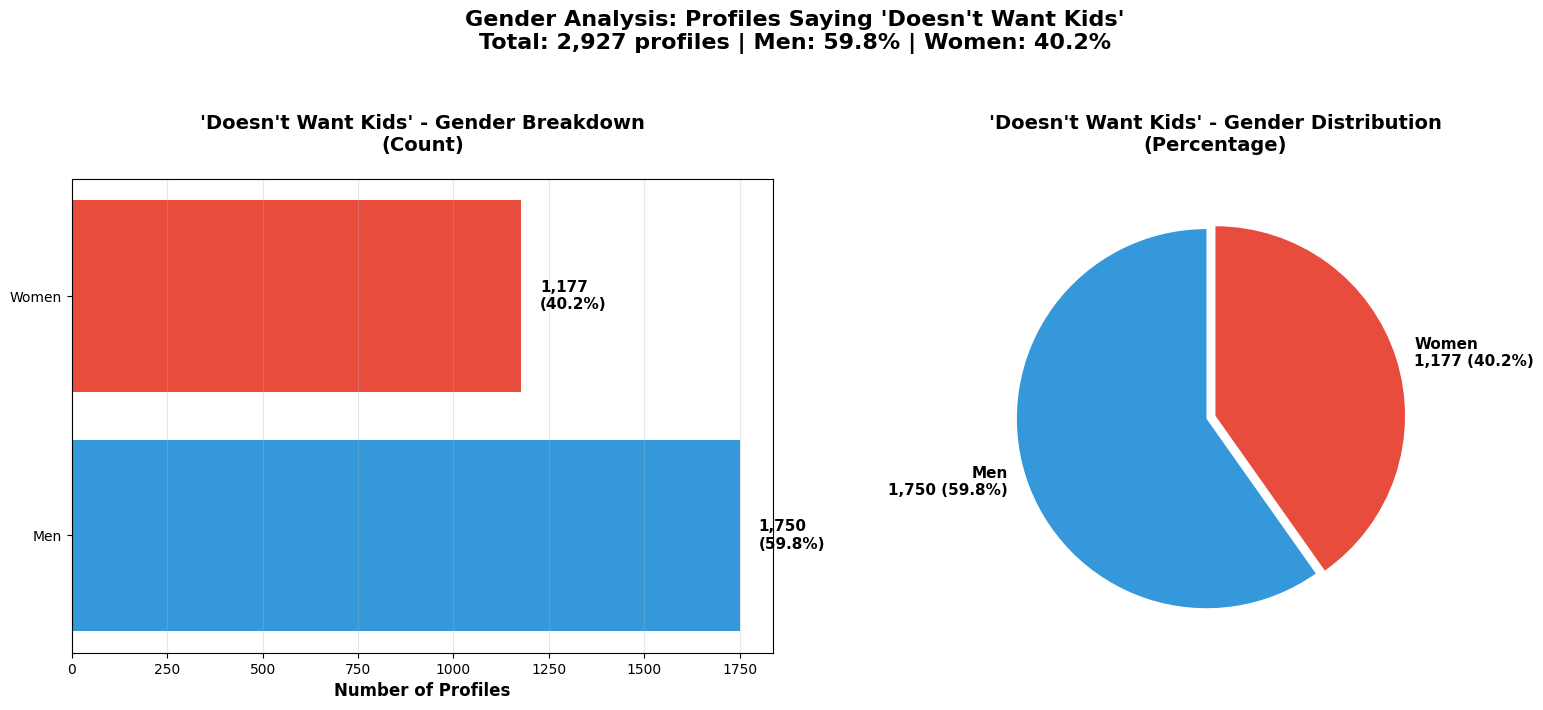

In [17]:
# Visualization 1: 4-Panel Breakdown for "Doesn't Want Kids"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for "doesn't want kids"
no_kids = df[df['offspring'] == "doesn't want kids"].copy()

# Count by gender
gender_counts = no_kids['sex'].value_counts()
total = len(no_kids)
male_count = gender_counts.get('m', 0)
female_count = gender_counts.get('f', 0)
male_pct = (male_count / total * 100) if total > 0 else 0
female_pct = (female_count / total * 100) if total > 0 else 0

print(f"Total profiles saying 'doesn't want kids': {total:,}")
print(f"Men: {male_count:,} ({male_pct:.1f}%)")
print(f"Women: {female_count:,} ({female_pct:.1f}%)")

# Create figure with 4 subplots
fig = plt.figure(figsize=(16, 12))
colors = ['#3498db', '#e74c3c']  # Blue for men, Red for women

# 1. Horizontal Bar Chart
ax1 = plt.subplot(2, 2, 1)
bars = ax1.barh(['Men', 'Women'], [male_count, female_count], color=colors)
ax1.set_xlabel('Number of Profiles', fontsize=12, fontweight='bold')
ax1.set_title("'Doesn't Want Kids' - Gender Breakdown\n(Count)", 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, [male_count, female_count], [male_pct, female_pct])):
    width = bar.get_width()
    ax1.text(width + 50, bar.get_y() + bar.get_height()/2, 
            f'{count:,}\n({pct:.1f}%)',
            ha='left', va='center', fontsize=11, fontweight='bold')

# 2. Pie Chart
ax2 = plt.subplot(2, 2, 2)
sizes = [male_count, female_count]
labels = [f'Men\n{male_count:,} ({male_pct:.1f}%)', 
          f'Women\n{female_count:,} ({female_pct:.1f}%)']
explode = (0.05, 0)  # Slightly explode the larger segment
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, 
                                   autopct='', explode=explode,
                                   startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title("'Doesn't Want Kids' - Gender Distribution\n(Percentage)", 
              fontsize=14, fontweight='bold', pad=20)

# Get all "doesn't want" related categories
doesnt_want_categories = [
    "doesn't want kids",
    "doesn't have kids, and doesn't want any"
]

plt.suptitle("Gender Analysis: Profiles Saying 'Doesn't Want Kids'\n" + 
             f"Total: {total:,} profiles | Men: {male_pct:.1f}% | Women: {female_pct:.1f}%",
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 📊 Stakeholder Visualizations: Body Type Preferences by Gender

Key Findings:
- **Men select fit/athletic body types far more often**
- **Women cluster in average/thin/curvy**


/var/folders/9j/j13nrnyx1mzfr87mqcn7zpqh0000gn/T/ipykernel_5952/3666552257.py:67: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/9j/j13nrnyx1mzfr87mqcn7zpqh0000gn/T/ipykernel_5952/3666552257.py:67: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/9j/j13nrnyx1mzfr87mqcn7zpqh0000gn/T/ipykernel_5952/3666552257.py:67: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gabisa/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gabisa/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gabisa/Library/Python/3.9/lib/python

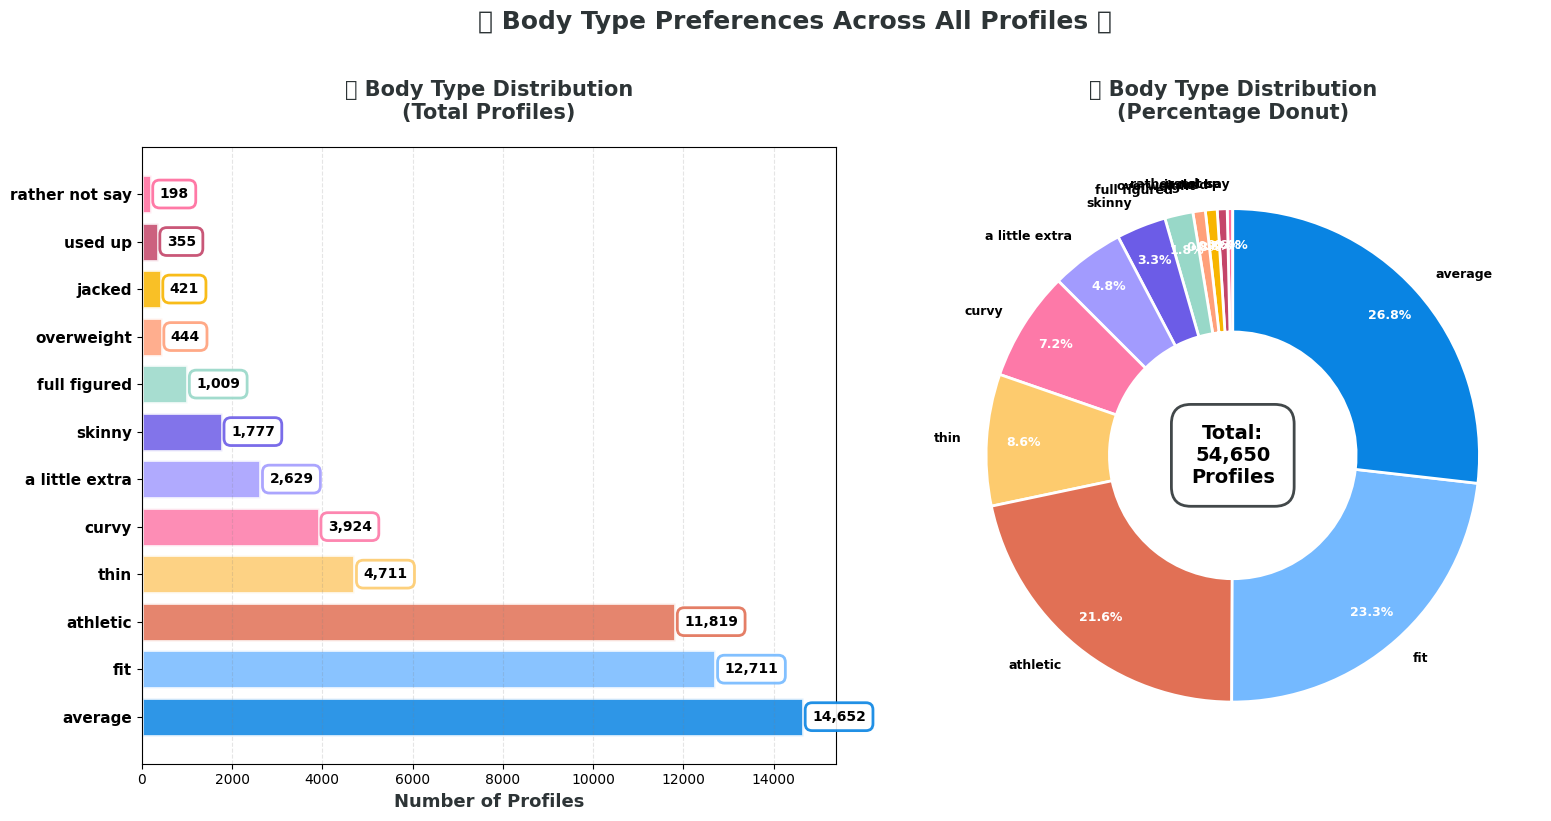


 BODY TYPE SUMMARY

 Top 3 Body Types:
  Athletic: 11,819 (21.6%)
  Fit: 12,711 (23.3%)
  Average: 14,652 (26.8%)

 Total Profiles: 54,650



In [18]:
# Visualization of Body Type Distribution
import matplotlib.pyplot as plt
import numpy as np

# Get body type counts from cell 10
body_type_counts = df['body_type'].value_counts()

# Create a fun, colorful visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Cute horizontal bar chart with emoji-style colors
colors_palette = ['#FF6B9D', '#C44569', '#F8B500', '#FFA07A', '#98D8C8', 
                  '#6C5CE7', '#A29BFE', '#FD79A8', '#FDCB6E', '#E17055', 
                  '#74B9FF', '#0984E3', '#00B894']

# Sort by count for better visualization
body_types_sorted = body_type_counts.sort_values(ascending=True)

bars = ax1.barh(range(len(body_types_sorted)), body_types_sorted.values, 
                color=colors_palette[:len(body_types_sorted)], 
                alpha=0.85, edgecolor='white', linewidth=2)

ax1.set_yticks(range(len(body_types_sorted)))
ax1.set_yticklabels(body_types_sorted.index, fontsize=11, fontweight='bold')
ax1.set_xlabel('Number of Profiles', fontsize=13, fontweight='bold', color='#2d3436')
ax1.set_title('💪 Body Type Distribution\n(Total Profiles)', 
              fontsize=15, fontweight='bold', pad=20, color='#2d3436')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.2, linestyle='--', color='gray')

# Add cute value labels with rounded corners effect
for i, (body_type, count) in enumerate(body_types_sorted.items()):
    ax1.text(count + 200, i, f'{count:,}',
            ha='left', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor=colors_palette[i], linewidth=2, alpha=0.9))

# Right: Cute donut chart
wedges, texts, autotexts = ax2.pie(body_types_sorted.values, 
                                   labels=body_types_sorted.index,
                                   colors=colors_palette[:len(body_types_sorted)],
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   pctdistance=0.85,
                                   textprops={'fontsize': 9, 'fontweight': 'bold'},
                                   wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2))

# Make percentage text larger and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

ax2.set_title('🍩 Body Type Distribution\n(Percentage Donut)', 
              fontsize=15, fontweight='bold', pad=20, color='#2d3436')

# Add total count in center
total = body_types_sorted.sum()
ax2.text(0, 0, f'Total:\n{total:,}\nProfiles', 
         ha='center', va='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round,pad=1', facecolor='white', 
                  edgecolor='#2d3436', linewidth=2, alpha=0.9))

plt.suptitle('✨ Body Type Preferences Across All Profiles ✨', 
             fontsize=18, fontweight='bold', y=1.02, color='#2d3436')

plt.tight_layout()
plt.show()

# Print cute summary
print(f"\n{'='*60}")
print(" BODY TYPE SUMMARY")
print(f"{'='*60}")
print(f"\n Top 3 Body Types:")
for i, (body_type, count) in enumerate(body_types_sorted.tail(3).items(), 1):
    pct = (count / total * 100)
    print(f"  {body_type.title()}: {count:,} ({pct:.1f}%)")
print(f"\n Total Profiles: {total:,}")
print(f"{'='*60}\n")

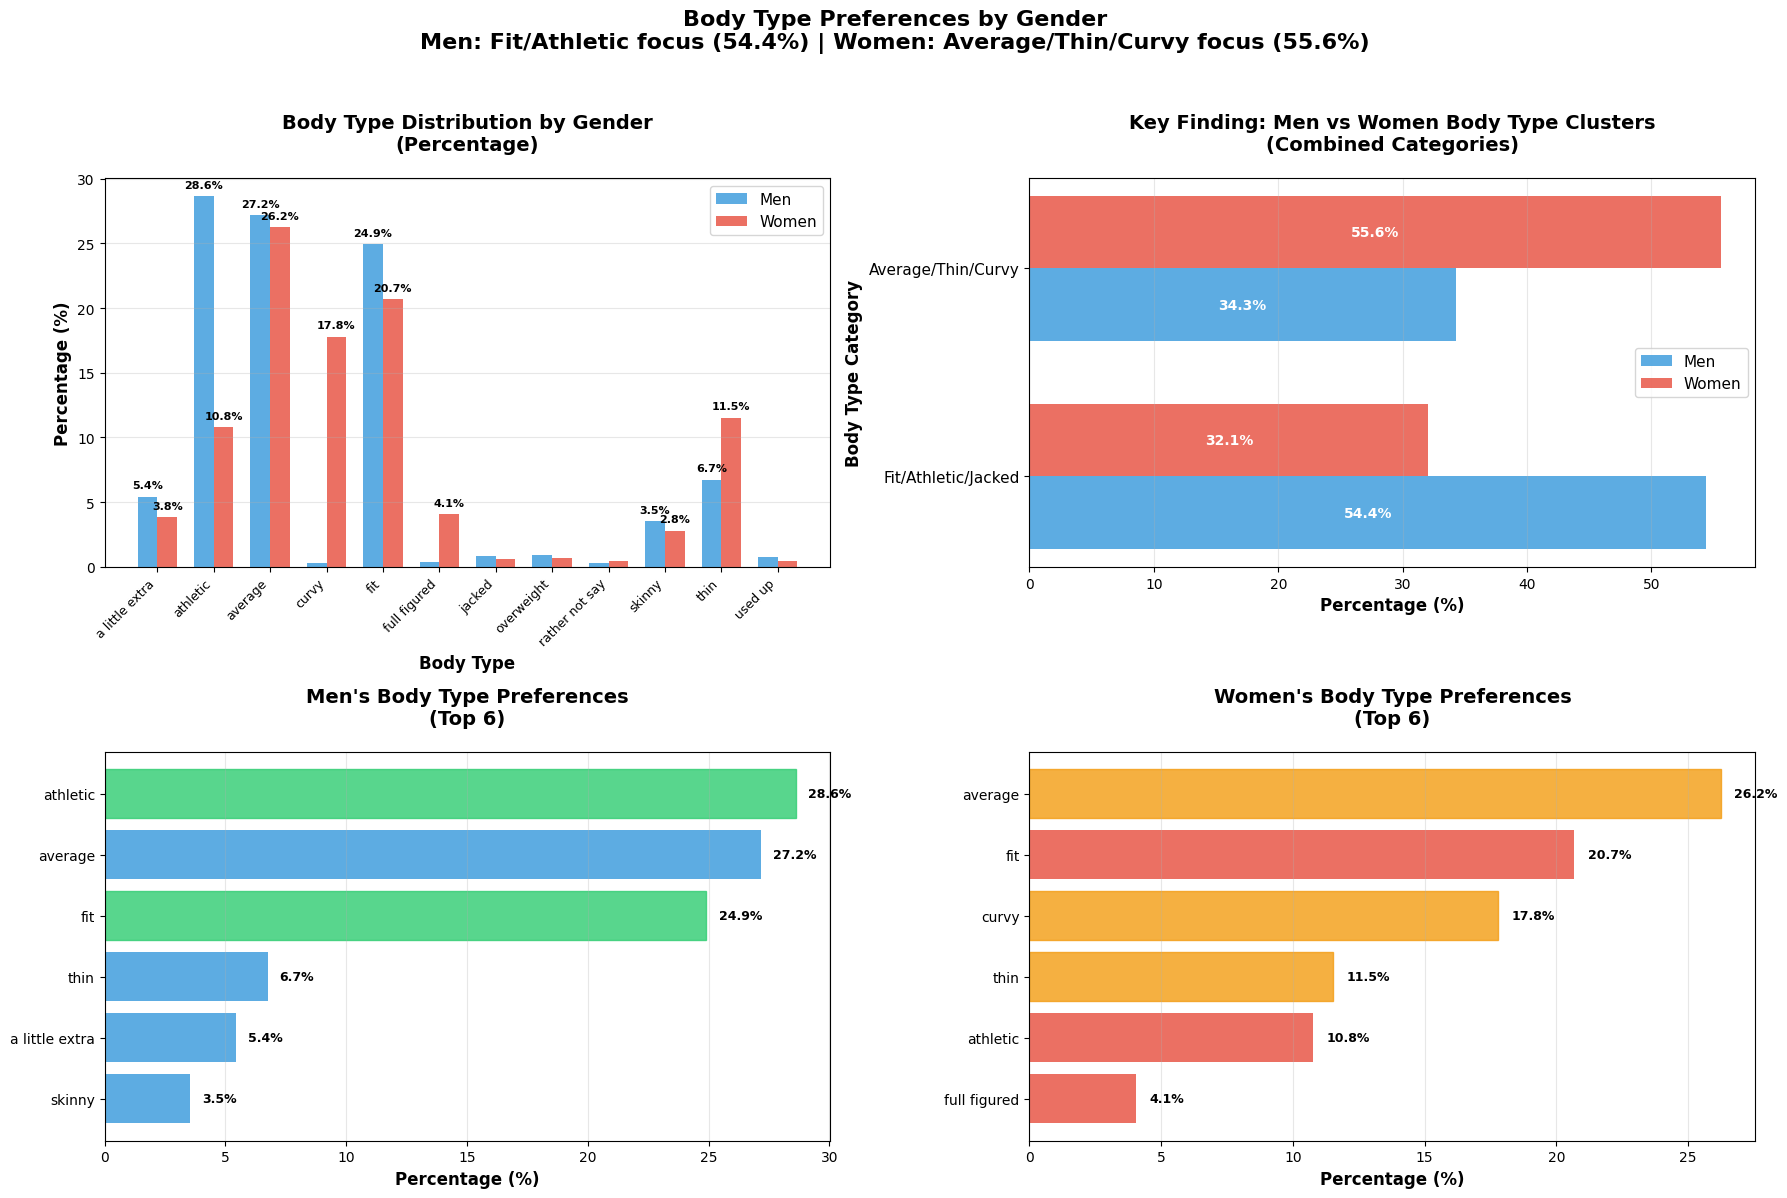


BODY TYPE PREFERENCES SUMMARY

Men's Top Body Types:
  athletic: 28.6%
  average: 27.2%
  fit: 24.9%
  thin: 6.7%
  a little extra: 5.4%

Women's Top Body Types:
  average: 26.2%
  fit: 20.7%
  curvy: 17.8%
  thin: 11.5%
  athletic: 10.8%

Key Finding: Men select fit/athletic/jacked: 54.4%
             Women cluster in average/thin/curvy: 55.6%


In [19]:
# Body Type Visualization 1: Gender Breakdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out NaN values
df_body = df[df['body_type'].notna() & df['sex'].notna()].copy()

# Create cross-tabulation (normalized by gender)
crosstab_pct = pd.crosstab(df_body['sex'], df_body['body_type'], normalize='index') * 100

# Create cross-tabulation (raw counts)
crosstab_counts = pd.crosstab(df_body['sex'], df_body['body_type'])

# Define body type categories
men_focused = ['fit', 'athletic', 'jacked']  # Men select these more
women_focused = ['average', 'thin', 'curvy']  # Women cluster in these

# Create figure with 4 subplots
fig = plt.figure(figsize=(18, 12))
colors = ['#3498db', '#e74c3c']  # Blue for men, Red for women

# 1. Stacked Bar Chart - Percentage by Gender
ax1 = plt.subplot(2, 2, 1)
body_types = crosstab_pct.columns.tolist()
men_pcts = crosstab_pct.loc['m'].values
women_pcts = crosstab_pct.loc['f'].values

x = np.arange(len(body_types))
width = 0.35

bars1 = ax1.bar(x - width/2, men_pcts, width, label='Men', color=colors[0], alpha=0.8)
bars2 = ax1.bar(x + width/2, women_pcts, width, label='Women', color=colors[1], alpha=0.8)

ax1.set_xlabel('Body Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Body Type Distribution by Gender\n(Percentage)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(body_types, rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 2:  # Only label if significant
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Horizontal Stacked Bar - Focus on Key Categories
ax2 = plt.subplot(2, 2, 2)

# Calculate percentages for key categories
men_fit_athletic = crosstab_pct.loc['m', ['fit', 'athletic', 'jacked']].sum()
women_fit_athletic = crosstab_pct.loc['f', ['fit', 'athletic', 'jacked']].sum()
men_avg_thin_curvy = crosstab_pct.loc['m', ['average', 'thin', 'curvy']].sum()
women_avg_thin_curvy = crosstab_pct.loc['f', ['average', 'thin', 'curvy']].sum()

categories = ['Fit/Athletic/Jacked', 'Average/Thin/Curvy']
men_values = [men_fit_athletic, men_avg_thin_curvy]
women_values = [women_fit_athletic, women_avg_thin_curvy]

x2 = np.arange(len(categories))
bars1_2 = ax2.barh(x2 - width/2, men_values, width, label='Men', color=colors[0], alpha=0.8)
bars2_2 = ax2.barh(x2 + width/2, women_values, width, label='Women', color=colors[1], alpha=0.8)

ax2.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Body Type Category', fontsize=12, fontweight='bold')
ax2.set_title('Key Finding: Men vs Women Body Type Clusters\n(Combined Categories)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_yticks(x2)
ax2.set_yticklabels(categories, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (m_val, w_val) in enumerate(zip(men_values, women_values)):
    ax2.text(m_val/2, i - width/2, f'{m_val:.1f}%', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    ax2.text(w_val/2, i + width/2, f'{w_val:.1f}%', 
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# 3. Detailed Comparison - Men's Top Body Types
ax3 = plt.subplot(2, 2, 3)
men_sorted = crosstab_pct.loc['m'].sort_values(ascending=False)
top_men_types = men_sorted.head(6)

bars3 = ax3.barh(range(len(top_men_types)), top_men_types.values, color=colors[0], alpha=0.8)
ax3.set_yticks(range(len(top_men_types)))
ax3.set_yticklabels(top_men_types.index, fontsize=10)
ax3.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_title("Men's Body Type Preferences\n(Top 6)", fontsize=14, fontweight='bold', pad=20)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# Highlight fit/athletic
for i, (body_type, pct) in enumerate(top_men_types.items()):
    if body_type in ['fit', 'athletic', 'jacked']:
        bars3[i].set_color('#2ecc71')  # Green highlight
    ax3.text(pct + 0.5, i, f'{pct:.1f}%', 
            ha='left', va='center', fontsize=9, fontweight='bold')

# 4. Detailed Comparison - Women's Top Body Types
ax4 = plt.subplot(2, 2, 4)
women_sorted = crosstab_pct.loc['f'].sort_values(ascending=False)
top_women_types = women_sorted.head(6)

bars4 = ax4.barh(range(len(top_women_types)), top_women_types.values, color=colors[1], alpha=0.8)
ax4.set_yticks(range(len(top_women_types)))
ax4.set_yticklabels(top_women_types.index, fontsize=10)
ax4.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
ax4.set_title("Women's Body Type Preferences\n(Top 6)", fontsize=14, fontweight='bold', pad=20)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Highlight average/thin/curvy
for i, (body_type, pct) in enumerate(top_women_types.items()):
    if body_type in ['average', 'thin', 'curvy']:
        bars4[i].set_color('#f39c12')  # Orange highlight
    ax4.text(pct + 0.5, i, f'{pct:.1f}%', 
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.suptitle("Body Type Preferences by Gender\n" + 
             f"Men: Fit/Athletic focus ({men_fit_athletic:.1f}%) | " +
             f"Women: Average/Thin/Curvy focus ({women_avg_thin_curvy:.1f}%)",
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("BODY TYPE PREFERENCES SUMMARY")
print(f"{'='*60}")
print(f"\nMen's Top Body Types:")
for body_type, pct in men_sorted.head(5).items():
    print(f"  {body_type}: {pct:.1f}%")
print(f"\nWomen's Top Body Types:")
for body_type, pct in women_sorted.head(5).items():
    print(f"  {body_type}: {pct:.1f}%")
print(f"\n{'='*60}")
print(f"Key Finding: Men select fit/athletic/jacked: {men_fit_athletic:.1f}%")
print(f"             Women cluster in average/thin/curvy: {women_avg_thin_curvy:.1f}%")
print(f"{'='*60}")

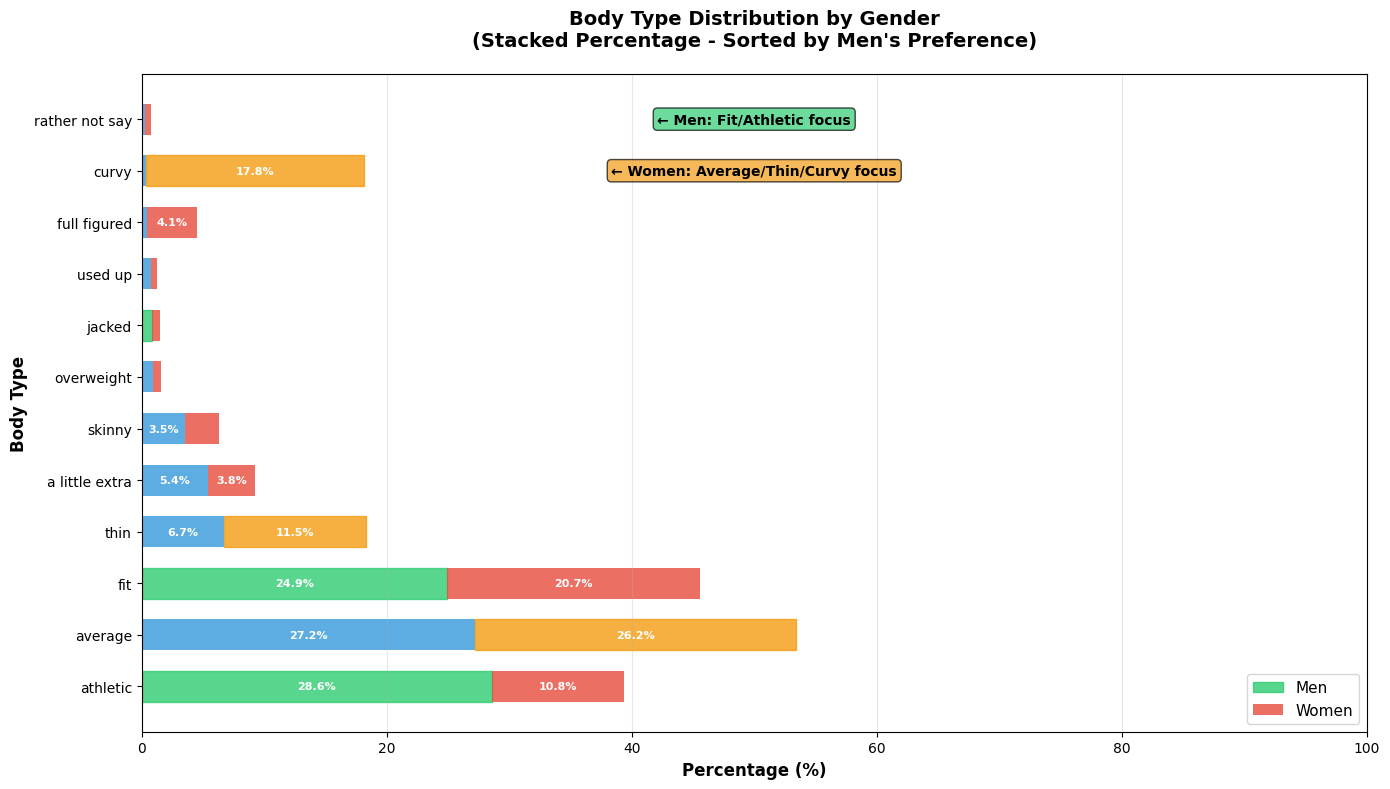

In [20]:
# Body Type Visualization 3: Stacked Percentage Chart
fig, ax = plt.subplots(figsize=(14, 8))

# Get all body types sorted by men's percentage
body_types_all = crosstab_pct.columns.tolist()
men_all_pcts = crosstab_pct.loc['m'].values
women_all_pcts = crosstab_pct.loc['f'].values

# Sort by men's percentage (descending) for better visualization
sort_idx = np.argsort(men_all_pcts)[::-1]
body_types_sorted = [body_types_all[i] for i in sort_idx]
men_sorted_pcts = men_all_pcts[sort_idx]
women_sorted_pcts = women_all_pcts[sort_idx]

# Create horizontal stacked bars
x = np.arange(len(body_types_sorted))
width = 0.6

bars1 = ax.barh(x, men_sorted_pcts, width, label='Men', color='#3498db', alpha=0.8)
bars2 = ax.barh(x, women_sorted_pcts, width, left=men_sorted_pcts, label='Women', color='#e74c3c', alpha=0.8)

# Highlight key categories
for i, body_type in enumerate(body_types_sorted):
    if body_type in ['fit', 'athletic', 'jacked']:
        bars1[i].set_color('#2ecc71')  # Green for men's fit/athletic
    elif body_type in ['average', 'thin', 'curvy']:
        bars2[i].set_color('#f39c12')  # Orange for women's average/thin/curvy

ax.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Body Type', fontsize=12, fontweight='bold')
ax.set_title('Body Type Distribution by Gender\n(Stacked Percentage - Sorted by Men\'s Preference)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(body_types_sorted, fontsize=10)
ax.set_xlim(0, 100)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Add percentage labels for significant segments
for i, (m_pct, w_pct) in enumerate(zip(men_sorted_pcts, women_sorted_pcts)):
    if m_pct > 3:  # Only label if segment is large enough
        ax.text(m_pct/2, i, f'{m_pct:.1f}%', 
               ha='center', va='center', fontsize=8, fontweight='bold', color='white')
    if w_pct > 3:
        ax.text(m_pct + w_pct/2, i, f'{w_pct:.1f}%', 
               ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# Add annotations for key findings
ax.text(50, len(body_types_sorted) - 1, '← Men: Fit/Athletic focus', 
       ha='center', va='center', fontsize=10, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.7))
ax.text(50, len(body_types_sorted) - 2, '← Women: Average/Thin/Curvy focus', 
       ha='center', va='center', fontsize=10, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='#f39c12', alpha=0.7))

plt.tight_layout()
plt.show()

In [21]:
#Top Keywords by gender
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=3000)
X = cv.fit_transform(df["clean_text"])

# get two groups
straight_men = (df["sex"] == "m") & (df["orientation"] == "straight")
straight_women = (df["sex"] == "f") & (df["orientation"] == "straight")

men_freq = X[straight_men.to_numpy()].sum(axis=0).A1
women_freq = X[straight_women.to_numpy()].sum(axis=0).A1

vocab = cv.get_feature_names_out()

# Convert numpy int64 to regular Python int for cleaner output
top_men = sorted(zip([int(f) for f in men_freq], vocab), reverse=True)[:30]
top_women = sorted(zip([int(f) for f in women_freq], vocab), reverse=True)[:30]

In [22]:
print("Top 15 male words:", top_men)
print("Top 15 female words:", top_women)

Top 15 male words: [(70880, 'like'), (48650, 'love'), (46111, 'good'), (44018, 'music'), (39264, 'people'), (38269, 'friends'), (36238, 'time'), (35859, 'just'), (35837, 'life'), (33114, 'things'), (31593, 'food'), (28931, 'new'), (27827, 'don'), (27321, 'really'), (24688, 'movies'), (23743, 'work'), (23303, 'know'), (23101, 've'), (22620, 'want'), (20366, 'think'), (19554, 'books'), (19102, 'going'), (19049, 'enjoy'), (17753, 'family'), (17743, 'fun'), (16658, 'working'), (16653, 'make'), (16299, 'lot'), (14973, 'pretty'), (14551, 'world')]
Top 15 female words: [(52752, 'love'), (44692, 'like'), (33082, 'friends'), (31131, 'good'), (28279, 'music'), (27047, 'life'), (26765, 'people'), (24782, 'time'), (22803, 'food'), (22078, 'things'), (21709, 'just'), (21529, 'new'), (18963, 'don'), (18365, 'really'), (17720, 'family'), (16971, 'movies'), (15480, 'work'), (15168, 'know'), (14658, 'books'), (14343, 'want'), (13899, 've'), (13694, 'enjoy'), (13596, 'going'), (13127, 'think'), (12447, 

### Load classifier + inspect strongest coefficients

In [ ]:
# Load the trained model and vectorizer
import joblib

clf = joblib.load('classifier/gender_classifier.pkl')
tfidf = joblib.load('classifier/tfidf_vectorizer.pkl')

print("Model and vectorizer loaded successfully!")

Model and vectorizer loaded successfully!


In [24]:
import numpy as np

coef = clf.coef_[0]
words = tfidf.get_feature_names_out()

top_male_words = words[np.argsort(coef)][-15:]
top_female_words = words[np.argsort(coef)][:15]

In [25]:
# Create dictionary with word counts from df['clean_text']
from collections import Counter

# Combine all words from both lists
all_key_words = list(top_female_words) + list(top_male_words)

# Join all clean_text and split into words
all_text = ' '.join(df['clean_text'].astype(str))
all_words = all_text.split()

# Count occurrences of each key word
word_counts = Counter(all_words)

# Create dictionary with only the key words
word_count_dict = {word: word_counts.get(word, 0) for word in all_key_words}

print("Word count dictionary:")
for word, count in sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{word}: {count}")

# Also store it as a variable for later use
word_frequency_dict = word_count_dict

Word count dictionary:
love: 120724
family: 40430
guy: 15254
dancing: 14006
girl: 11483
hair: 9205
sports: 8805
laughing: 7312
women: 5742
yoga: 5688
sunshine: 5404
chocolate: 5402
guitar: 5210
boy: 3471
baking: 2400
software: 2205
motorcycle: 2156
cars: 2090
fixing: 1965
computers: 1844
engineer: 1784
engineering: 1445
gay: 1444
father: 1347
adore: 1059
beard: 1023
heels: 1017
gal: 712
sewing: 637
lip: 576


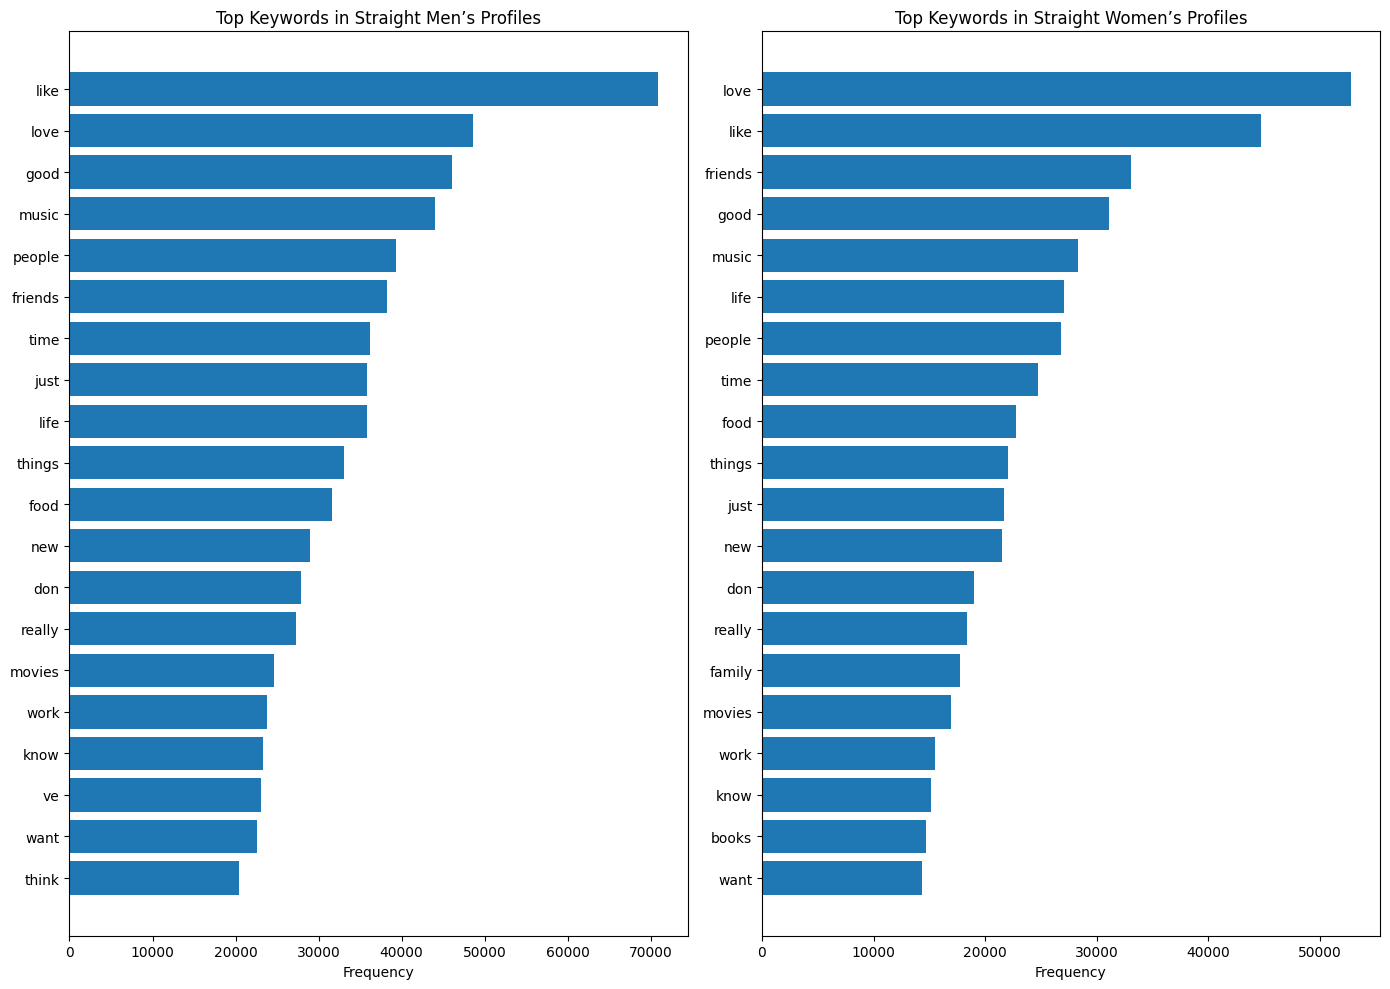

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Extract words + freq
men_words = [w for _, w in top_men[:20]]
men_freqs = [f for f, _ in top_men[:20]]

women_words = [w for _, w in top_women[:20]]
women_freqs = [f for f, _ in top_women[:20]]

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Men's words
y = np.arange(len(men_words))
axes[0].barh(y, men_freqs)
axes[0].set_yticks(y)
axes[0].set_yticklabels(men_words)
axes[0].invert_yaxis()
axes[0].set_title("Top Keywords in Straight Men’s Profiles")
axes[0].set_xlabel("Frequency")

# Women's words
y = np.arange(len(women_words))
axes[1].barh(y, women_freqs)
axes[1].set_yticks(y)
axes[1].set_yticklabels(women_words)
axes[1].invert_yaxis()
axes[1].set_title("Top Keywords in Straight Women’s Profiles")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()

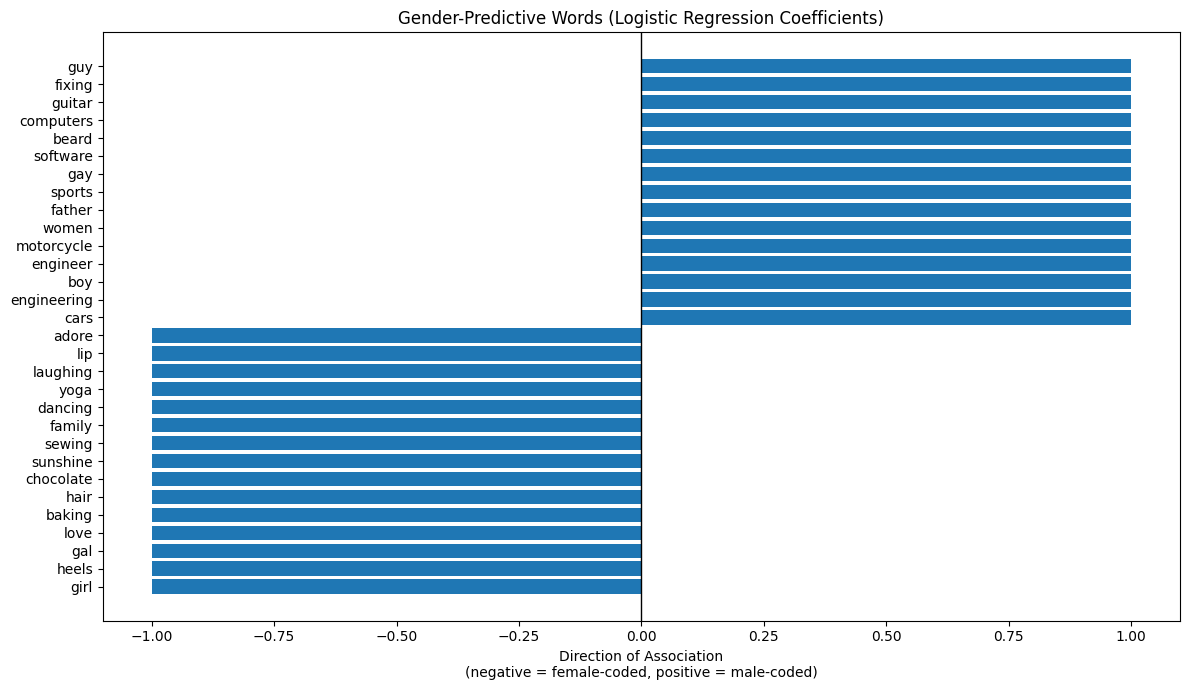

In [27]:
# Select strongest coefficients
top_female = list(top_female_words[:15])
top_male = list(top_male_words[:15])

fig, ax = plt.subplots(figsize=(12, 7))

# Combine for one plot
words = top_female + top_male
effects = [-1] * len(top_female) + [1] * len(top_male)  # -1 -> female-coded, +1 -> male-coded

y_pos = np.arange(len(words))

ax.barh(y_pos, effects)
ax.set_yticks(y_pos)
ax.set_yticklabels(words)

ax.set_title("Gender-Predictive Words (Logistic Regression Coefficients)")
ax.set_xlabel("Direction of Association\n(negative = female-coded, positive = male-coded)")
ax.axvline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

## 6) Topic modeling

In [28]:
# Topic Modeling (NMF)
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf2 = TfidfVectorizer(stop_words="english", min_df=30, max_df=0.7)
X2 = tfidf2.fit_transform(df["clean_text"])

nmf = NMF(n_components=12, random_state=0)
W = nmf.fit_transform(X2)
H = nmf.components_

words = tfidf2.get_feature_names_out()

# Topic labels
topic_labels = {
    0: "Relationships (romantic life)",
    1: "Casual (chill/lol/chat)",
    2: "Thoughts (opinions/talking)",
    3: "Entertainment (movies/games)",
    4: "Aesthetics (art/music/vibes)",
    5: "Location (Bay Area)",
    6: "Lifestyle (fun/travel/dates)",
    7: "Interaction (messaging/meeting)",
    8: "Exploring (new things/places)",
    9: "Company (conversation/wine)",
    10: "Warmth (home/food/family vibes)",
    11: "Outdoors (active/hiking)"
}

for i, topic in enumerate(H):
    top = [words[i] for i in topic.argsort()[-15:]]
    print(f"Topic {i}: {topic_labels[i]} - {top}")

/Users/gabisa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/gabisa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/gabisa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


Topic 0: Relationships (romantic life) - ['man', 'sense', 'person', 'live', 'great', 'partner', 'nature', 'enjoy', 'woman', 'share', 'looking', 'relationship', 'world', 'open', 'life']
Topic 1: Casual (chill/lol/chat) - ['money', 'school', 'just', 'chill', 'haha', 'really', 'wanna', 'life', 'alot', 'ill', 'thats', 'ive', 'lol', 'dont', 'im']
Topic 2: Thoughts (opinions/talking) - ['make', 'probably', 'pretty', 'say', 'know', 'time', 'll', 'lot', 'just', 'things', 'people', 'think', 've', 'really', 'don']
Topic 3: Entertainment (movies/games) - ['watch', 'playing', 'school', 'video', 'movie', 'watching', 'rock', 'tv', 'shows', 'books', 'games', 'food', 'music', 'movies', 'favorite']
Topic 4: Aesthetics (art/music/vibes) - ['http', 'men', 'rock', 'bike', 'john', 'hot', 'coffee', 'dead', 'com', 'david', 'books', 'making', 'black', 'art', 'music']
Topic 5: Location (Bay Area) - ['living', 'east', 'recently', 'ago', 'lived', 'year', 've', 'sf', 'area', 'city', 'years', 'bay', 'moved', 'fran

/Users/gabisa/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [29]:
# Create topic column from NMF results
df["topic"] = W.argmax(axis=1)
print(f"Topic column created. Shape: {df['topic'].shape}")
print(f"Topic distribution:\n{df['topic'].value_counts().sort_index()}")

Topic column created. Shape: (59946,)
Topic distribution:
topic
0     7456
1     2330
2     9261
3     5363
4     9257
5     4539
6     4292
7     3449
8     3338
9     3652
10    4326
11    2683
Name: count, dtype: int64


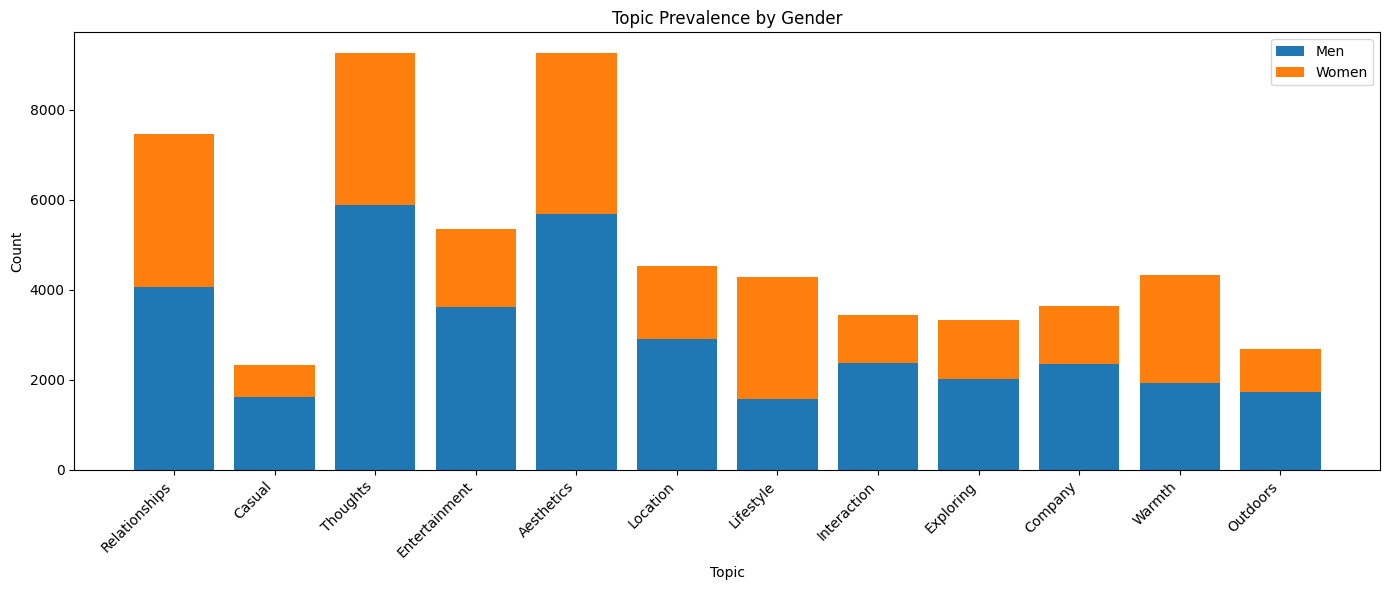

In [30]:
topic_counts = df.groupby(["sex", "topic"]).size().unstack().fillna(0)

# Topic labels
topic_labels = {
    0: "Relationships",
    1: "Casual",
    2: "Thoughts",
    3: "Entertainment",
    4: "Aesthetics",
    5: "Location",
    6: "Lifestyle",
    7: "Interaction",
    8: "Exploring",
    9: "Company",
    10: "Warmth",
    11: "Outdoors"
}

fig, ax = plt.subplots(figsize=(14, 6))

men_values = topic_counts.loc["m"]
women_values = topic_counts.loc["f"]
topics = np.arange(len(men_values))

ax.bar(topics, men_values, label="Men")
ax.bar(topics, women_values, bottom=men_values, label="Women")

ax.set_xticks(topics)
ax.set_xticklabels([topic_labels[i] for i in topics], rotation=45, ha='right')
ax.set_title("Topic Prevalence by Gender")
ax.set_xlabel("Topic")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()
plt.show()

In [31]:
df["topic"] = W.argmax(axis=1)
df.groupby(["sex", "topic"]).size().unstack().fillna(0)

topic,0,1,2,3,4,5,6,7,8,9,10,11
sex,,,,,,,,,,,,
f,3383,699,3367,1738,3571,1632,2722,1068,1308,1295,2393,941
m,4073,1631,5894,3625,5686,2907,1570,2381,2030,2357,1933,1742


## 7) Emotion analysis (NRCLex)

In [32]:
# Sentiment + Emotion
from nrclex import NRCLex

def get_emotions(text):
    e = NRCLex(text)
    return e.raw_emotion_scores

df["emotions"] = df["clean_text"].apply(get_emotions)

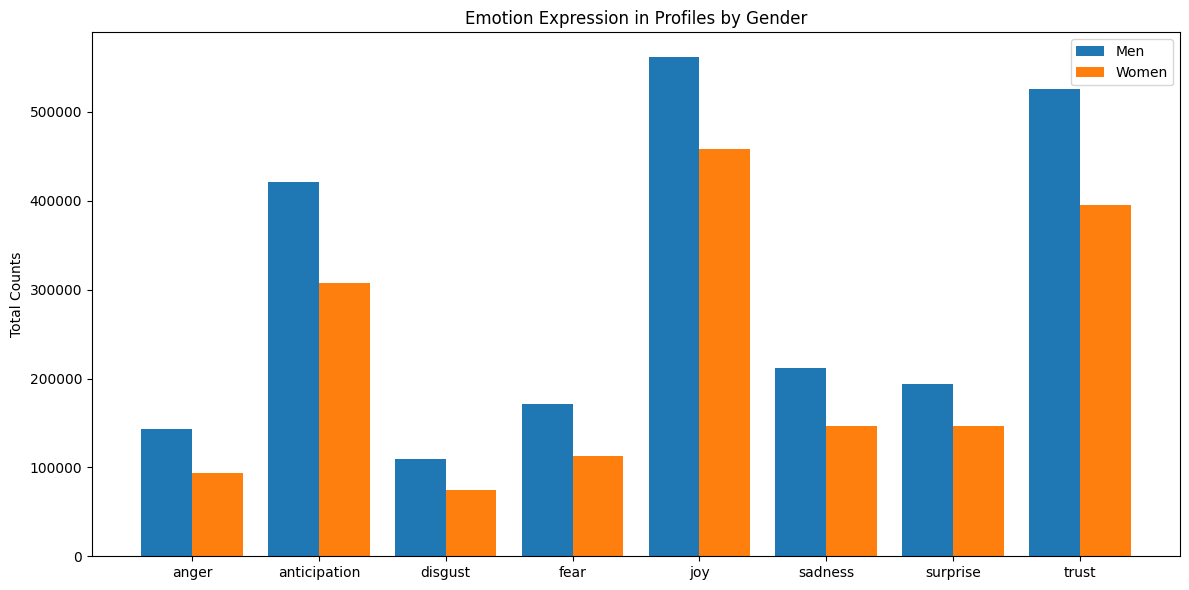

In [33]:
emotion_categories = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']

def sum_emotions(group):
    agg = {e:0 for e in emotion_categories}
    for row in group:
        for k,v in row.items():
            if k in agg:
                agg[k] += v
    return [agg[e] for e in emotion_categories]

men_emotions = sum_emotions(df[df["sex"]=="m"]["emotions"])
women_emotions = sum_emotions(df[df["sex"]=="f"]["emotions"])

x = np.arange(len(emotion_categories))

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - 0.2, men_emotions, width=0.4, label="Men")
ax.bar(x + 0.2, women_emotions, width=0.4, label="Women")

ax.set_xticks(x)
ax.set_xticklabels(emotion_categories)
ax.set_title("Emotion Expression in Profiles by Gender")
ax.set_ylabel("Total Counts")
ax.legend()

plt.tight_layout()
plt.show()

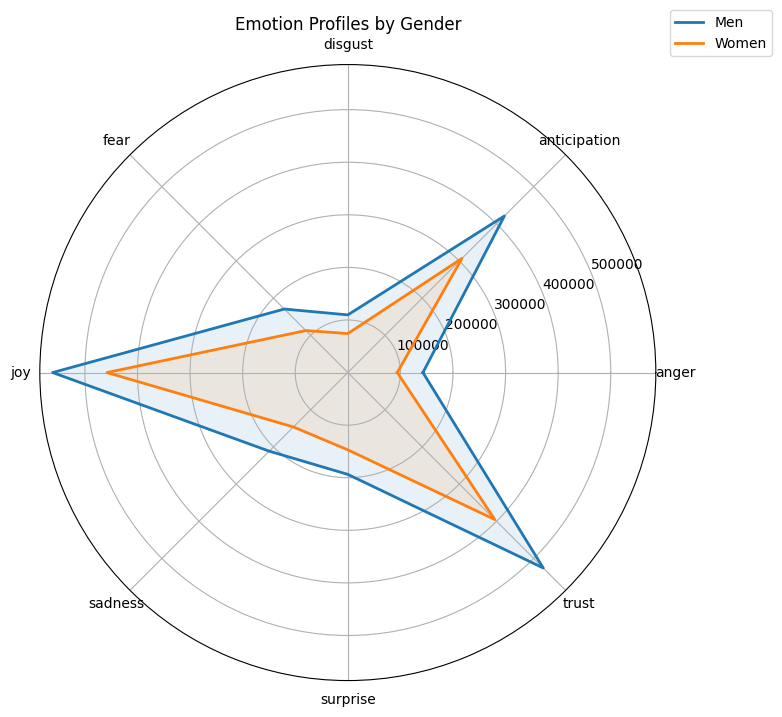

In [34]:
labels = emotion_categories
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

# close loop
men = np.array(men_emotions + men_emotions[:1])
women = np.array(women_emotions + women_emotions[:1])
angles = angles + angles[:1]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

ax.plot(angles, men, linewidth=2, label="Men")
ax.plot(angles, women, linewidth=2, label="Women")

ax.fill(angles, men, alpha=0.1)
ax.fill(angles, women, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Emotion Profiles by Gender")

ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

## Appendix: Older / prototype cells (optional)
These cells were in the original notebook but are not required for the main pipeline above. Keep here for reference / comparison.

In [35]:
# Create cross-tabulation
crosstab = pd.crosstab(
    df_filtered['offspring'],
    df_filtered['sex'],
    normalize='index'
) * 100

# Ensure all key_categories are present and in this order
crosstab = crosstab.reindex(key_categories).fillna(0)

# Prepare data
categories = crosstab.index.tolist()

label_map = {
    "doesn't have kids, and doesn't want any": "No kids, doesn't want any",
    "doesn't want kids": "Doesn't want kids",
    "doesn't have kids, but wants them": "No kids, wants them",
    "has a kid, and might want more": "Has 1 kid, might want more",
    "has a kid, but doesn't want more": "Has 1 kid, done",
    "has kids, and might want more": "Has kids, might want more",
    "has kids, but doesn't want more": "Has kids, done",
}

category_labels = [label_map[c] for c in categories]

male_pcts   = crosstab.get('m', pd.Series([0]*len(categories), index=categories)).values
female_pcts = crosstab.get('f', pd.Series([0]*len(categories), index=categories)).values

x = np.arange(len(categories))
width = 0.6

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.barh(x, male_pcts, width, label='Men', color='#3498db')
bars2 = ax.barh(x, female_pcts, width, left=male_pcts, label='Women', color='#e74c3c')

ax.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Offspring Preference', fontsize=12, fontweight='bold')
ax.set_title('Gender Breakdown Across Selected Offspring Preferences\n(Stacked Percentage)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(category_labels, fontsize=10)
ax.set_xlim(0, 100)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Add percentage labels (same as before)
for i, (m_pct, f_pct) in enumerate(zip(male_pcts, female_pcts)):
    if m_pct > 5:
        ax.text(m_pct/2, i, f'{m_pct:.1f}%', ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')
    if f_pct > 5:
        ax.text(m_pct + f_pct/2, i, f'{f_pct:.1f}%', ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

NameError: name 'df_filtered' is not defined

In [ ]:
#Combine all Essay Columns 
import pandas as pd

essay_cols = [f"essay{i}" for i in range(10)]
df["text"] = df[essay_cols].fillna("").agg(" ".join, axis=1)

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# assume df contains 'sex' and 'essay' columns
df_clean = df[df['sex'].isin(['m','f'])].copy()

# simple emotion lexicon (you can replace with NRC if downloaded)
positive_words = {
    # LOVE / AFFECTION
    "love","adore","cherish","value","treasure","appreciate","admire","embrace",
    "fondness","affection","devotion","tenderness","attachment","care_for",

    # CARE / SUPPORTIVENESS
    "care","nurture","support","uplift","comfort","soothe","reassure","encourage",
    "protect","help","assist","look_after","be_there","stand_by","back_up",
    "empathy","compassion","kindness","warmth","gentleness",

    # FEEL / EMOTIONALLY OPEN
    "feel","sense","experience","be_present","share","express","open_up","relate",
    "resonate","understand","listen","notice","acknowledge",
    
    # CONNECTION / RELATIONALITY
    "connect","bond","together","unite","belong","join","align","link","reach_out",
    "communicate","relate_to","grow_with","build_with","partner","collaborate",
    "togetherness","closeness","intimacy","solidarity","community",

    # WARM / POSITIVE EMOTIONAL STATE
    "warm","bright","gentle","soft","calm","peaceful","secure","safe","hopeful",
    "joyful","happy","content","grateful","positive","uplifting","harmonious",
    "balanced","supported","loved"
}

negative_words = {
    # LONELINESS / ISOLATION
    "lonely","isolated","alone","abandoned","disconnected","detached","unseen",
    "unheard","neglected","ignored","withdrawn","left_out","alienated",

    # STRESS / ANXIETY / PRESSURE
    "stress","stressed","overwhelmed","tense","anxious","worried","pressured",
    "frazzled","burned_out","maxed_out","on_edge","uneasy","restless",
    "strained","loaded","burdened","at_capacity","chaotic",

    # TIRED / EXHAUSTED / FATIGUE
    "tired","exhausted","drained","fatigued","worn_out","weary","sleepy",
    "burnt","depleted","sluggish","low_energy","slowed_down","spent",

    # HURT / PAIN / SADNESS
    "hurt","wounded","broken","aching","bruised","pained","upset","sad",
    "down","low","heartbroken","discouraged","disappointed","struggling",
    "suffering","hurtful","in_pain","unwell"
}

def emotion_counts(text):
    tokens = [t.lower() for t in text.split()]
    pos = sum(t in positive_words for t in tokens)
    neg = sum(t in negative_words for t in tokens)
    return pd.Series({"pos":pos,"neg":neg})

df_emotions = df_clean['clean_text'].apply(emotion_counts)
df_out = pd.concat([df_clean[['sex']], df_emotions], axis=1)

df_out.groupby('sex').mean()

In [ ]:
# Professional Minimalist Visualization: Emotion Analysis by Gender
import matplotlib.pyplot as plt
import numpy as np

# Run the emotion analysis (from previous cell)
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Simple emotion lexicon
positive_words = {
    "love","adore","cherish","value","treasure","appreciate","admire","embrace",
    "fondness","affection","devotion","tenderness","attachment","care_for",
    "care","nurture","support","uplift","comfort","soothe","reassure","encourage",
    "protect","help","assist","look_after","be_there","stand_by","back_up",
    "empathy","compassion","kindness","warmth","gentleness",
    "feel","sense","experience","be_present","share","express","open_up","relate",
    "resonate","understand","listen","notice","acknowledge",
    "connect","bond","together","unite","belong","join","align","link","reach_out",
    "communicate","relate_to","grow_with","build_with","partner","collaborate",
    "togetherness","closeness","intimacy","solidarity","community",
    "warm","bright","gentle","soft","calm","peaceful","secure","safe","hopeful",
    "joyful","happy","content","grateful","positive","uplifting","harmonious",
    "balanced","supported","loved"
}

negative_words = {
    "lonely","isolated","alone","abandoned","disconnected","detached","unseen",
    "unheard","neglected","ignored","withdrawn","left_out","alienated",
    "stress","stressed","overwhelmed","tense","anxious","worried","pressured",
    "frazzled","burned_out","maxed_out","on_edge","uneasy","restless",
    "strained","loaded","burdened","at_capacity","chaotic",
    "tired","exhausted","drained","fatigued","worn_out","weary","sleepy",
    "burnt","depleted","sluggish","low_energy","slowed_down","spent",
    "hurt","wounded","broken","aching","bruised","pained","upset","sad",
    "down","low","heartbroken","discouraged","disappointed","struggling",
    "suffering","hurtful","in_pain","unwell"
}

def emotion_counts(text):
    tokens = [t.lower() for t in text.split()]
    pos = sum(t in positive_words for t in tokens)
    neg = sum(t in negative_words for t in tokens)
    return pd.Series({"pos":pos,"neg":neg})

df_clean = df[df['sex'].isin(['m','f'])].copy()
df_emotions = df_clean['clean_text'].apply(emotion_counts)
df_out = pd.concat([df_clean[['sex']], df_emotions], axis=1)
emotion_means = df_out.groupby('sex').mean()

# Create minimalist professional visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Set minimalist style
plt.style.use('default')
colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'men': '#3498db', 'women': '#e91e63'}

# Left: Grouped bar chart
categories = ['Positive', 'Negative']
men_values = [emotion_means.loc['m', 'pos'], emotion_means.loc['m', 'neg']]
women_values = [emotion_means.loc['f', 'pos'], emotion_means.loc['f', 'neg']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, men_values, width, label='Men', 
                color=colors['men'], alpha=0.85, edgecolor='white', linewidth=1.5)
bars2 = ax1.bar(x + width/2, women_values, width, label='Women', 
                color=colors['women'], alpha=0.85, edgecolor='white', linewidth=1.5)

ax1.set_ylabel('Average Word Count', fontsize=11, fontweight='500')
ax1.set_title('Emotional Expression by Gender', fontsize=13, fontweight='600', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(categories, fontsize=11)
ax1.legend(fontsize=10, frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.1, linestyle='-', linewidth=0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='500')

# Right: Side-by-side comparison
ax2.barh(['Men', 'Women'], [emotion_means.loc['m', 'pos'], emotion_means.loc['f', 'pos']], 
         color=colors['positive'], alpha=0.7, label='Positive', height=0.4)
ax2.barh(['Men', 'Women'], [emotion_means.loc['m', 'neg'], emotion_means.loc['f', 'neg']], 
         left=[emotion_means.loc['m', 'pos'], emotion_means.loc['f', 'pos']],
         color=colors['negative'], alpha=0.7, label='Negative', height=0.4)

ax2.set_xlabel('Average Word Count', fontsize=11, fontweight='500')
ax2.set_title('Emotional Expression Breakdown', fontsize=13, fontweight='600', pad=15)
ax2.legend(['Positive', 'Negative'], fontsize=10, frameon=False, loc='lower right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.1, linestyle='-', linewidth=0.5)

# Add value labels for stacked bars
for i, (gender, pos_val, neg_val) in enumerate([('m', emotion_means.loc['m', 'pos'], emotion_means.loc['m', 'neg']),
                                                  ('f', emotion_means.loc['f', 'pos'], emotion_means.loc['f', 'neg'])]):
    ax2.text(pos_val/2, i, f'{pos_val:.2f}', ha='center', va='center', 
            fontsize=9, fontweight='500', color='white')
    ax2.text(pos_val + neg_val/2, i, f'{neg_val:.2f}', ha='center', va='center', 
            fontsize=9, fontweight='500', color='white')

plt.tight_layout()
plt.show()

# Print clean summary
print(f"\n{'─'*50}")
print("Emotion Analysis Summary")
print(f"{'─'*50}")
print(f"\nMen:")
print(f"  Positive words: {emotion_means.loc['m', 'pos']:.2f} (avg per profile)")
print(f"  Negative words: {emotion_means.loc['m', 'neg']:.2f} (avg per profile)")
print(f"\nWomen:")
print(f"  Positive words: {emotion_means.loc['f', 'pos']:.2f} (avg per profile)")
print(f"  Negative words: {emotion_means.loc['f', 'neg']:.2f} (avg per profile)")
print(f"{'─'*50}\n")